In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import network
from numba import jit, njit, double, int64
from numba_progress import ProgressBar

# Aufgabe 5 
> Zielsetzung:
- Faltung bei gradueller Abkühlung von $T_0 = 10$ auf $T_1 = 1$
- Auftragung der von Energie über Zeit (Monte-Carlo-Schritte), Vergleich mit ex4
- Auftragung von Energie und Größe (End-Abstand) über Temperatur 
- Veränderung bei $T_1 < 1$

> Durchführung der Monte-Carlo-Simulation mit annealing ($T_1 = 1$), für zeitlichen Energieverlauf (keine Mittelung bei konstanter Temperatur): 

In [2]:
@njit(nogil=True)
def monte_carlo(protein, temperature_0, temperature_1, number_of_steps, progress_proxy):
    
    temperature = np.linspace(temperature_0, temperature_1, int(number_of_steps))
    simulation = np.zeros(int(number_of_steps), dtype=double)
    for step in range(number_of_steps):
        simulation[step] = protein.calc_energy()
        protein.random_fold_step(temperature[step])
        progress_proxy.update(1)
    
    return simulation

steps = 1e6
T_0 = 10
T_1 = 1
p = network.create_protein(interaction_type='normal')
p2 = network.Protein(np.copy(p.chain), np.copy(p.J))

with ProgressBar(total=2*steps) as progress:
    arr = monte_carlo(p, T_0, T_1, steps, progress)
    arr2 = monte_carlo(p2, T_0, T_1, steps, progress)

  0%|          | 0/2000000.0 [00:00<?, ?it/s]

> Auftragung analog zu ex4:

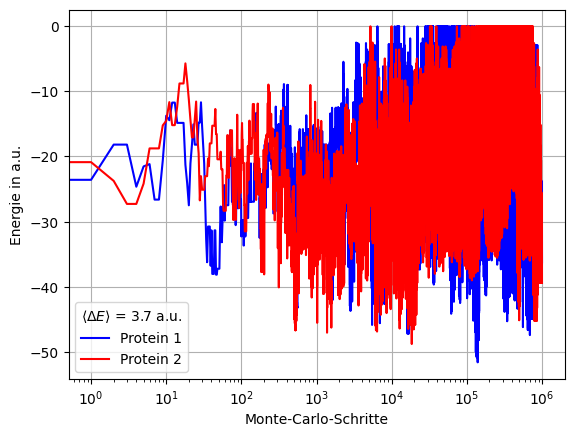

In [3]:
@jit((double[:])(int64, double[:]))
def energyBounds(number_of_steps, simulation):

    energy = np.zeros(number_of_steps, dtype=double)
    min_energy = 0
    last_energy = 0
    threshold = 0.3
    last_peak = False
    
    for i in range(number_of_steps):
        current_energy = simulation[i]
        
        if current_energy <= min_energy-1:
            if last_peak:
                energy[i] = abs(last_energy - min_energy)
                
                
            min_energy = current_energy
            last_peak = False
            
        if current_energy > min_energy:
            last_peak = True
            
        last_energy = current_energy
    energy = energy[energy > threshold]
    return energy[energy!=0] 

fig, ax = plt.subplots()

ax.set_xlabel('Monte-Carlo-Schritte')
ax.set_ylabel('Energie in a.u.')
ax.set_xscale('log')
plt.grid()

bounds = energyBounds(steps, arr)
bounds2 = energyBounds(steps, arr2)
bounds = np.concatenate((bounds, bounds2))

label =''
if len(bounds) > 0:
    label = r'$\langle \Delta E \rangle$ = '+str(round(np.mean(bounds), 2))+' a.u.'
ax.plot(np.arange(steps), arr, color='blue', label='Protein 1')
ax.plot(np.arange(steps), arr2, color='red', label='Protein 2')

if len(bounds) > 0:
    plt.legend(loc='lower left', title=label)

> Struktur der gefalteten Proteine mit Größenangabe

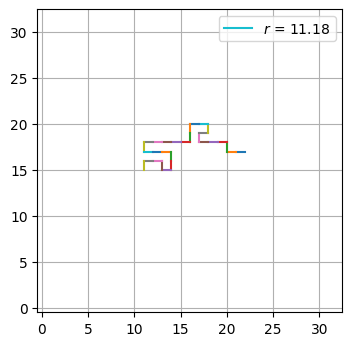

In [4]:
network.plot_protein(p)

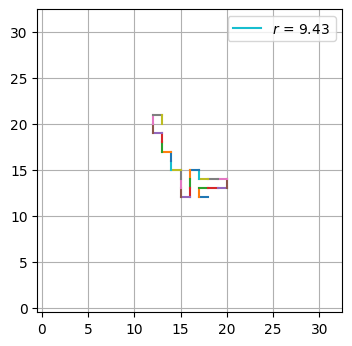

In [5]:
network.plot_protein(p2)

> Durchführung der Monte-Carlo-Simulation mit annealing ($T_1 = 1$), für Temperaturabhängigkeit von Protein-Energie und -Größe (jeweils Mittelung über $n=10^7$ Monte-Carlo-Schritte pro Temperaturschritt):

In [3]:
@njit(nogil=True)
def monte_carlo_temperature(protein, temperature_0, temperature_1, number_of_steps, number_of_repeats, progress_proxy):
    
    temperature = np.linspace(temperature_0, temperature_1, number_of_steps)
    simulation = np.zeros(shape=(number_of_steps, 2), dtype=double)
    simulation[0][0] = protein.calc_energy()
    simulation[0][1] = protein.calc_size()
  
    for step in range(number_of_steps):
        energy_mean = 0
        size_mean = 0
        for temperature_step in range(number_of_repeats):
            
            protein.random_fold_step(temperature[step])
            energy_mean += protein.calc_energy()
            size_mean += protein.calc_size()
            progress_proxy.update(1)
            
        energy_mean /= number_of_repeats
        size_mean /= number_of_repeats
        
        simulation[step][0] = energy_mean
        simulation[step][1] = size_mean
        
    return simulation

steps = 200
repeats = 10000
T_0 = 10
T_1 = 1

num_of_proteins = 2
num_iterations = num_of_proteins * (steps * repeats - repeats)

p1 = network.create_protein(interaction_type='normal')
p2 = network.Protein(np.copy(p1.chain), np.copy(p1.J))

with ProgressBar(total=num_iterations) as progress:
    arr_T_1 = monte_carlo_temperature(p1, T_0, T_1, steps, repeats, progress)
    arr_T_2 = monte_carlo_temperature(p2, T_0, T_1, steps, repeats, progress)

energy_1 = arr_T_1[:, 0]
size_1 = arr_T_1[:, 1]
energy_2 = arr_T_2[:, 0]
size_2 = arr_T_2[:, 1]

  0%|          | 0/3980000 [00:00<?, ?it/s]

> Auftragung: Energie - Temperatur

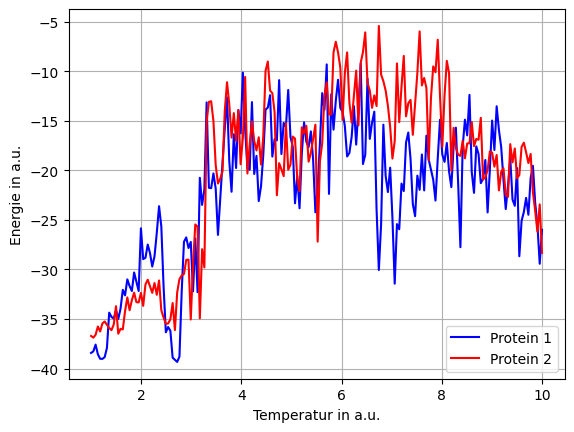

In [4]:
fig, ax = plt.subplots()

ax.set_xlabel('Temperatur in a.u.')
ax.set_ylabel('Energie in a.u.')
plt.grid()

ax.plot(np.linspace(T_0, T_1, int(steps)), energy_1, color='blue', label='Protein 1')
ax.plot(np.linspace(T_0, T_1, int(steps)), energy_2, color='red', label='Protein 2')
plt.legend(loc='lower right')


>Auftragung: Endenabstand - Temperatur

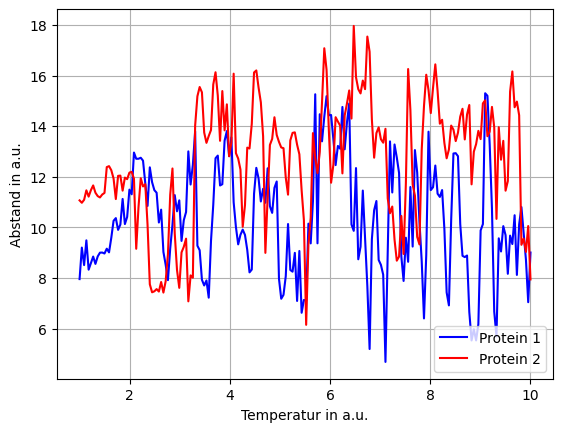

In [5]:
fig, ax = plt.subplots()

ax.set_xlabel('Temperatur in a.u.')
ax.set_ylabel('Abstand in a.u.')
plt.grid()

ax.plot(np.linspace(T_0, T_1, int(steps)), size_1, color='blue', label='Protein 1')
ax.plot(np.linspace(T_0, T_1, int(steps)), size_2, color='red', label='Protein 2')
plt.legend(loc='lower right')

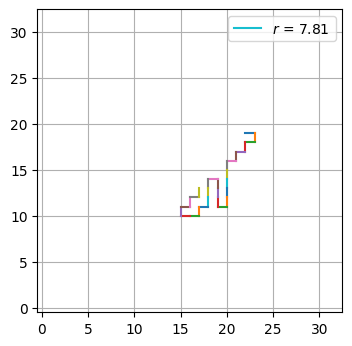

In [6]:
network.plot_protein(p1)

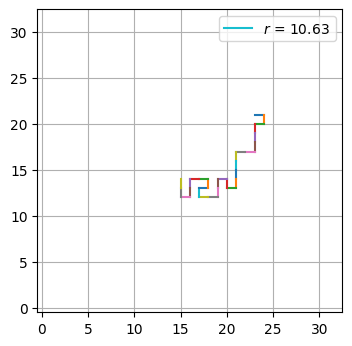

In [7]:
network.plot_protein(p2)

> Für $T_1 < 1$ ist die Konvergenz der Annahmewahrscheinlichkeit $p \propto \exp(-\Delta E / T) \rightarrow 0$ für die Annahme von Faltungen mit $\Delta E > 0$ zu beobachten. Das Protein verbleibt im erreichten (meta-)stabilen Zustand. Betrachte die folgenden Auftragungen eines Beispiels:

In [49]:
steps = 1000
repeats = 10000
num_iterations = steps * repeats
T_0 = 5
T_1 = 0.001
p = network.create_protein(interaction_type='normal')
with ProgressBar(total=num_iterations) as progress:
    arr_T = monte_carlo_temperature(p, T_0, T_1, steps, repeats, progress)
energy = arr_T[:, 0]
size = arr_T[:, 1]

  0%|          | 0/10000000 [00:00<?, ?it/s]

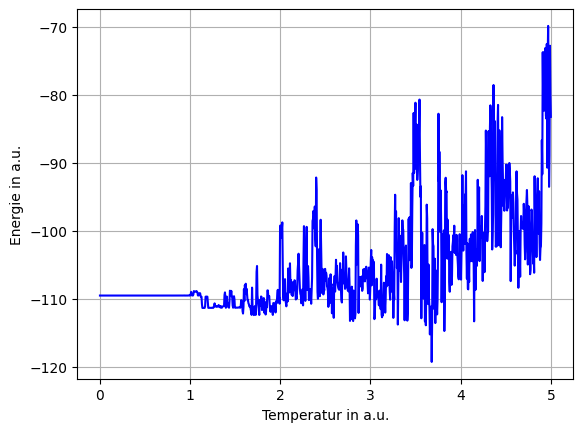

In [50]:
fig, ax = plt.subplots()

ax.set_xlabel('Temperatur in a.u.')
ax.set_ylabel('Energie in a.u.')
plt.grid()

ax.plot(np.linspace(T_0, T_1, int(steps)), energy, color='blue')

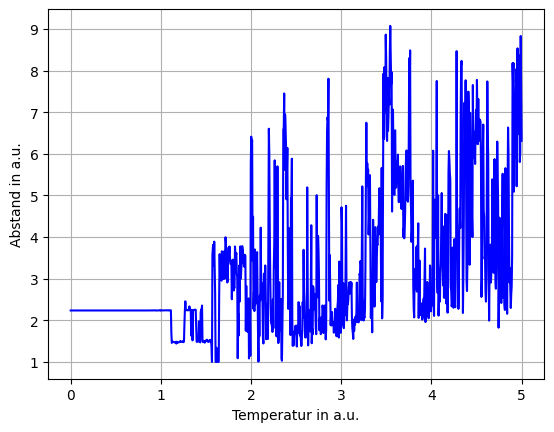

In [51]:
fig, ax = plt.subplots()

ax.set_xlabel('Temperatur in a.u.')
ax.set_ylabel('Abstand in a.u.')
plt.grid()

ax.plot(np.linspace(T_0, T_1, int(steps)), size, color='blue')

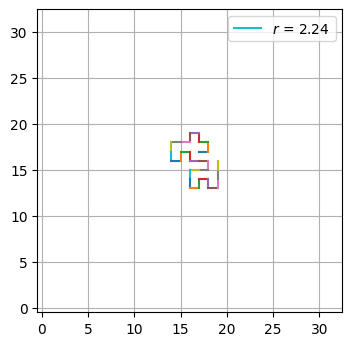

In [52]:
network.plot_protein(p)